# 多重スリットにおける回折・干渉実験の光の強度分布(3次元版)

### 必要なライブラリのインポート

In [1]:
#!pip install numba

In [2]:
%matplotlib notebook
import numpy as np
import cmath
import numba
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import LinearLocator

### 各種設定

In [3]:
# スリットースクリーン間距離
L = 1.0*10**2
# 光の波長
lam = 1.0*10**(-6)
# スクリーンの初期位置
x_0 = 10.0
# 波数
k = (2*np.pi)/lam
# スクリーン上の各点との距離を格納するリストの用意
R_points = []

![回折](回折.jpg) 

### numpy.meshgrid()を利用するための格子点の設定

In [4]:
# 格子の分割数
m = 257
# スクリーンのx,y座標の設定
X,Y = np.meshgrid(np.linspace(-x_0, x_0, m), np.linspace(-x_0, x_0, m))
# 強度分布格納用配列の初期化
I_points = np.zeros([m, m])

### 回転角の設定

In [5]:
# 回転角の設定
p_x = 0
p_y = np.pi/4
p_z = np.pi/4
Theta = np.array([p_x, p_y, p_z])

### 座標を回転させる関数の定義

In [6]:
def Rotation(Theta, df):
    # 回転行列
    theta_x = Theta[0]
    theta_y = Theta[1]
    theta_z = Theta[2]
    rotation_z = np.array([[np.cos(theta_z), np.sin(theta_z), 0],
                           [-np.sin(theta_z), np.cos(theta_z), 0],
                           [0, 0, 1]])
    rotation_y = np.array([[np.cos(theta_y), 0, -np.sin(theta_y)],
                           [0, 1, 0],
                           [np.sin(theta_y), 0, np.cos(theta_y)]])
    rotation_x = np.array([[1, 0, 0],
                           [0, np.cos(theta_x), np.sin(theta_x)],
                           [0, -np.sin(theta_x), np.cos(theta_x)]])
    Rotation_matrix = rotation_z@rotation_y@rotation_x
    
    arr_data = df.values
    # 行列積の計算
    new_data = Rotation_matrix@arr_data.T
    return new_data

### スリットの座標のデータフレームの作成

In [7]:
# x軸方向のスリット間距離
dx = 0.1
# y軸方向のスリット幅
dy = 0.1
# y軸方向のスリット幅
dz = 0.1
# スリット数(奇数限定)
N = 3
n = (N-1)*0.5
# スリット番号の配列
slit_number = np.arange(-n, n+1)

In [8]:
new_slit_number = []
i = 0
while(i<=1):
    for j in range(len(slit_number)):
        new_slit_number.append(slit_number[j])
    i += 1

new_slit_number = np.array(new_slit_number)
z_number = 0.5*np.ones(N)
new_z_number = np.append(z_number, [-z_number])

df_slit_data = pd.DataFrame(
    data = {'x': dx*new_slit_number, #x座標の指定
            'y': dy*np.ones(2*N), # y座標の指定
            'z': dz*new_z_number}
)

In [9]:
# 作成したデータフレームの確認
df_slit_data

,x,y,z
0,-0.1,0.1,0.05
1,0.0,0.1,0.05
2,0.1,0.1,0.05
3,-0.1,0.1,-0.05
4,0.0,0.1,-0.05
5,0.1,0.1,-0.05


In [10]:
#df_slit_data.drop(df_slit_data.index[[3, 4, 5]], inplace=True)

In [11]:
# 作成したデータフレームの確認
df_slit_data.values

array([[-0.1 ,  0.1 ,  0.05],
       [ 0.  ,  0.1 ,  0.05],
       [ 0.1 ,  0.1 ,  0.05],
       [-0.1 ,  0.1 , -0.05],
       [ 0.  ,  0.1 , -0.05],
       [ 0.1 ,  0.1 , -0.05]])

### bccの座標設定

In [12]:
df_bcc_data = pd.DataFrame(
    data = {'x': dx*np.array([0,0.5,-0.5, 0.5,-0.5, 0.5,-0.5, 0.5,-0.5]), #x座標の指定
            'y': dy*np.array([0,0.5, 0.5,-0.5,-0.5, 0.5, 0.5,-0.5,-0.5]), #y座標の指定
            'z': dz*np.array([0,0.5, 0.5, 0.5, 0.5,-0.5,-0.5,-0.5,-0.5])}
)

In [13]:
df_bcc_data.values

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.05,  0.05,  0.05],
       [-0.05,  0.05,  0.05],
       [ 0.05, -0.05,  0.05],
       [-0.05, -0.05,  0.05],
       [ 0.05,  0.05, -0.05],
       [-0.05,  0.05, -0.05],
       [ 0.05, -0.05, -0.05],
       [-0.05, -0.05, -0.05]])

### fccの座標設定

In [14]:
df_fcc_data = pd.DataFrame(
    data = {'x': dx*np.array([0,   0,   0,   0,  0.5, -0.5,0.5,-0.5, 0.5,-0.5, 0.5,-0.5, 0.5,-0.5]), #x座標の指定
            'y': dy*np.array([0,   0,   0.5,-0.5,0,    0,  0.5, 0.5,-0.5,-0.5, 0.5, 0.5,-0.5,-0.5]), #y座標の指定
            'z': dz*np.array([0.5,-0.5, 0,   0,  0,    0,  0.5, 0.5, 0.5, 0.5,-0.5,-0.5,-0.5,-0.5])}
)

In [15]:
df_fcc_data.values

array([[ 0.  ,  0.  ,  0.05],
       [ 0.  ,  0.  , -0.05],
       [ 0.  ,  0.05,  0.  ],
       [ 0.  , -0.05,  0.  ],
       [ 0.05,  0.  ,  0.  ],
       [-0.05,  0.  ,  0.  ],
       [ 0.05,  0.05,  0.05],
       [-0.05,  0.05,  0.05],
       [ 0.05, -0.05,  0.05],
       [-0.05, -0.05,  0.05],
       [ 0.05,  0.05, -0.05],
       [-0.05,  0.05, -0.05],
       [ 0.05, -0.05, -0.05],
       [-0.05, -0.05, -0.05]])

### 座標を回転

In [16]:
new_data = Rotation(Theta, df_bcc_data)

### 座標を抽出しリスト型に変換

In [17]:
# https://note.nkmk.me/python-pandas-numpy-conversion/
slit_coordinate_x = list(new_data[0])
slit_coordinate_y = list(new_data[1])
slit_coordinate_z = list(new_data[2])

### 回転後の座標のプロット

<IPython.core.display.Javascript object>


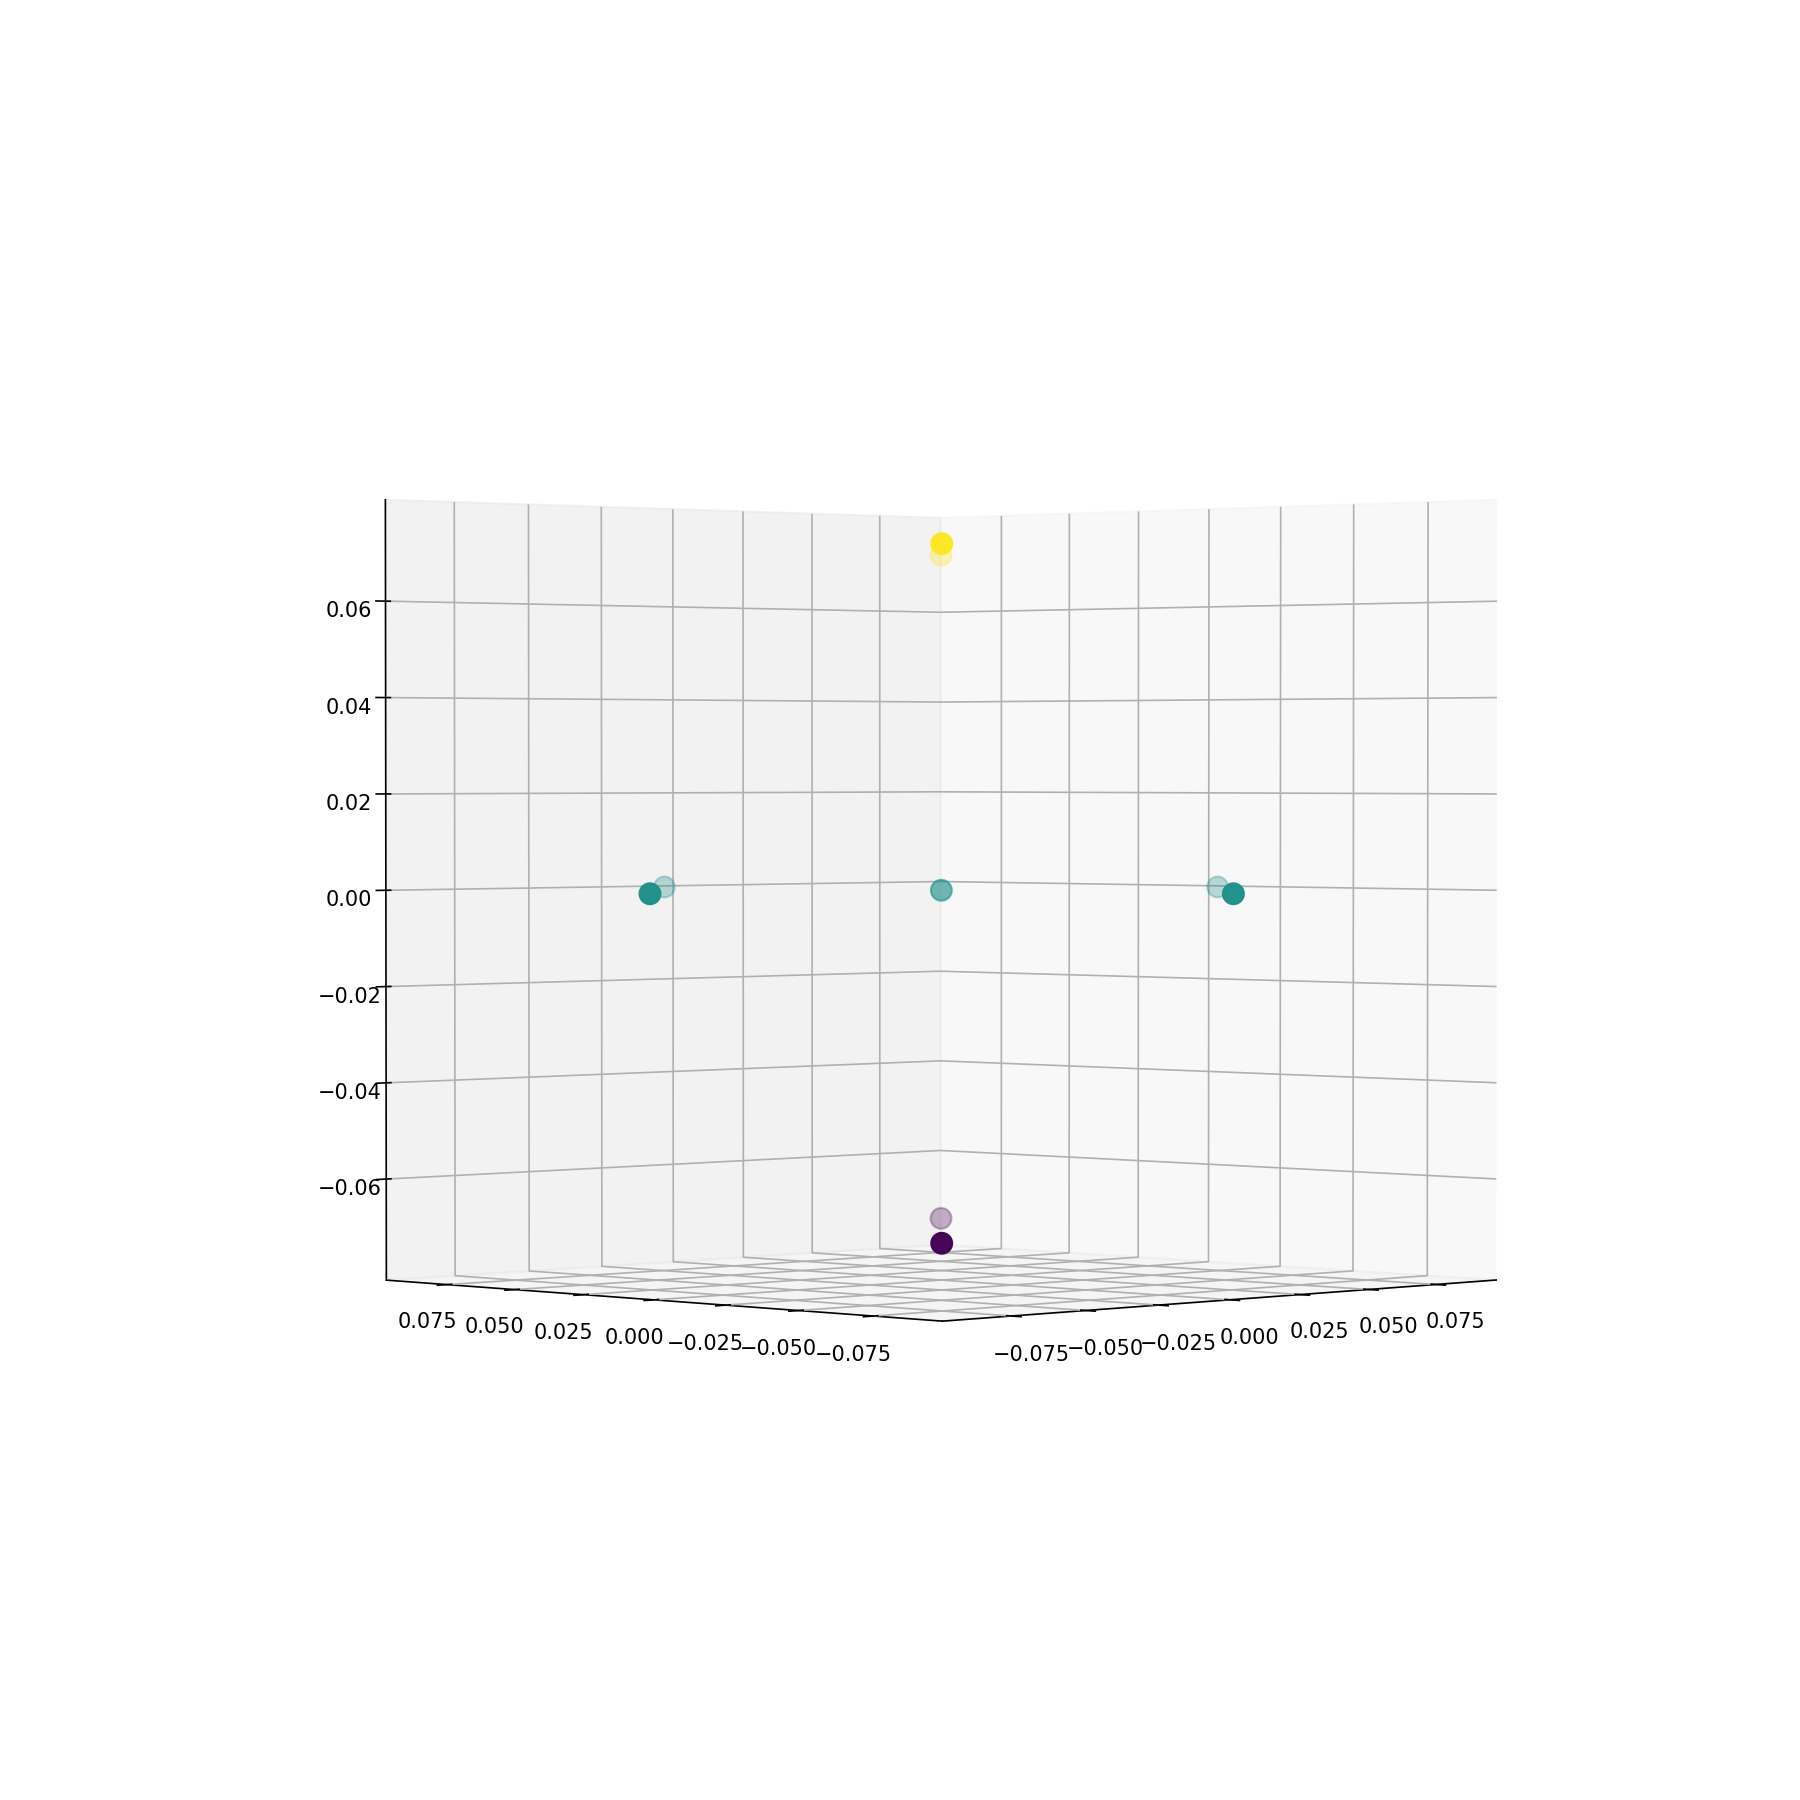

In [18]:
fig2 = plt.figure(
    figsize = (12, 12),
    facecolor = "white",
    edgecolor = "black",
)
ax3 = fig2.add_subplot(111, projection='3d')
ax3.scatter(slit_coordinate_x, slit_coordinate_y, slit_coordinate_z, s=100, c=slit_coordinate_z)
ax3.view_init(elev=0, azim=270)

### スリットの座標数

In [19]:
slit_count = len(slit_coordinate_x)

In [20]:
slit_count

9

### 各スリットからスクリーン上の点までの距離の計算

$$
R = \sqrt{(L-z)^2+(X-x)^2+(Y-y)^2}
$$

In [21]:
for i in range(slit_count):
    R = np.sqrt((L-slit_coordinate_z[i]**2)**2+(X-slit_coordinate_x[i])**2 + (Y-slit_coordinate_y[i])**2)
    R_points.append(R)
# リストを配列型に変換
R_points = np.array(R_points)

### 波の重ね合わせ（繰り返し処理）

In [22]:
@numba.jit
def calc_I(slit_count, m, k, R_points, I_points):
    for s in range(m):
        count = 0
        for t in range(m):
            # 電場の初期化
            E = 0
            for u in range(slit_count):
                # 電場の計算
                E += cmath.exp(1j*k*R_points[u, s, t])
            # 光強度の計算結果を格納
            I_points[s, count] = np.abs(E)**2
            count += 1

In [23]:
calc_I(slit_count, m, k, R_points, I_points)

### 光の強度分布，干渉縞のグラフ化

<IPython.core.display.Javascript object>


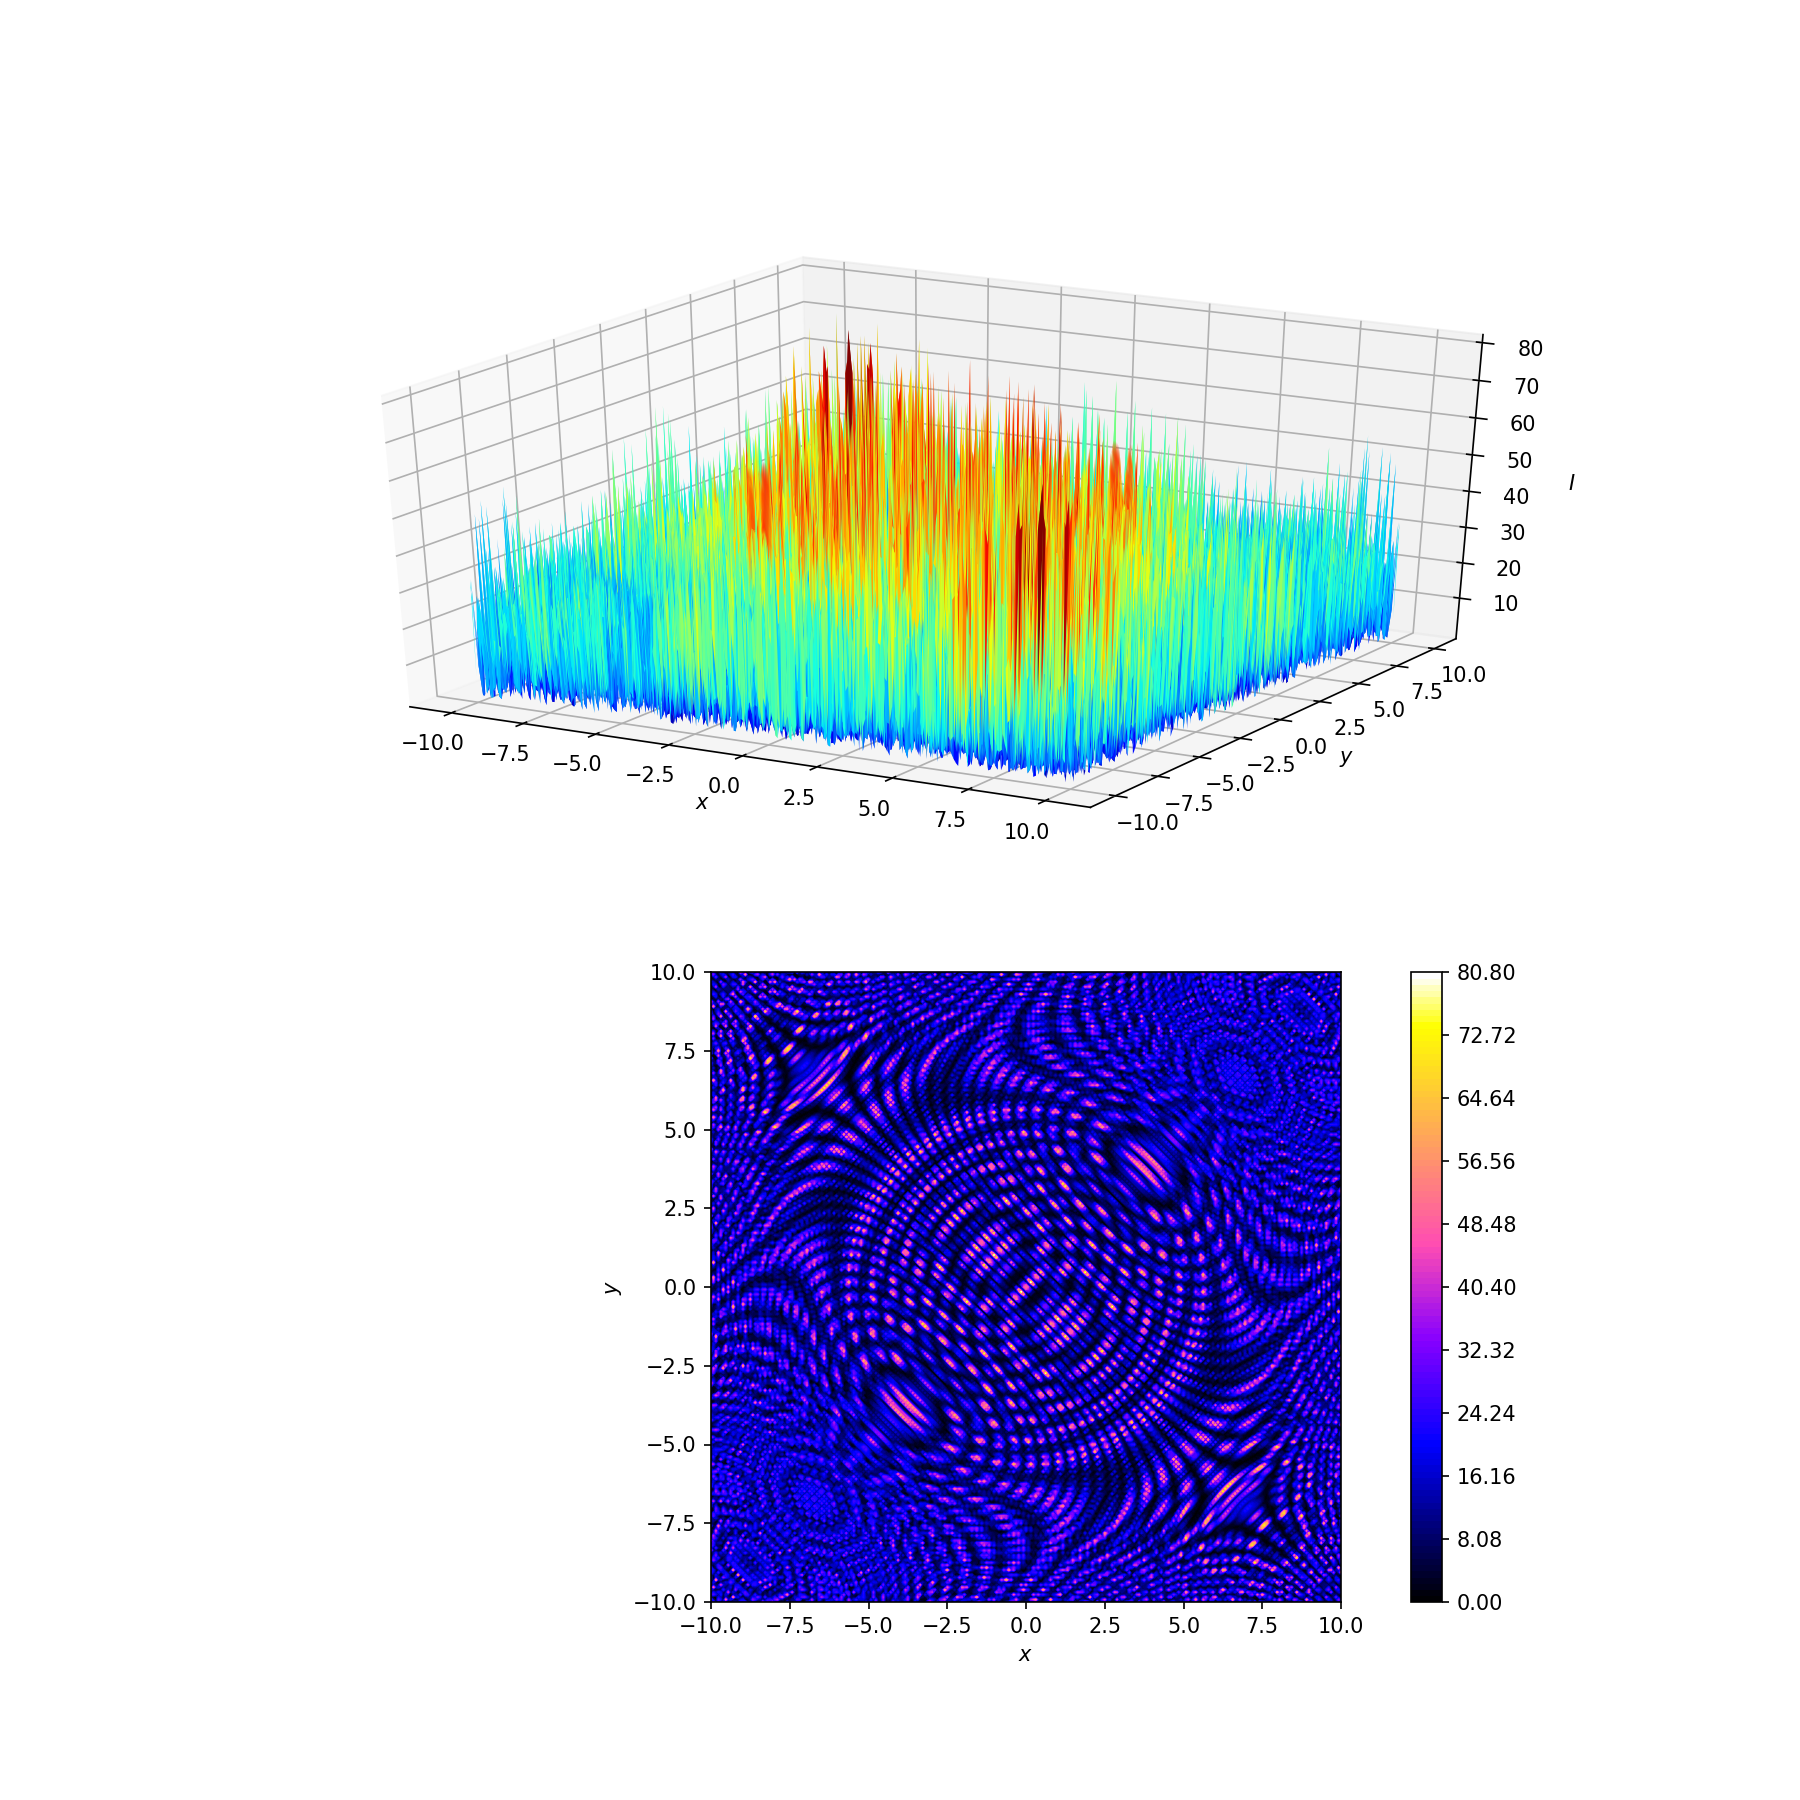

In [24]:
# https://learntutorials.net/ja/matplotlib/topic/3385/%E3%82%AB%E3%83%A9%E3%83%BC%E3%83%9E%E3%83%83%E3%83%97
fig = plt.figure(
    figsize = (12, 12),
    facecolor = "white",
    edgecolor = "black",
)

ax1 = fig.add_subplot(211, projection='3d')
ax1.plot_surface(X, Y, I_points, rstride=1, cstride=1, cmap='jet')

ax2 = fig.add_subplot(212)
# ３次元の等高線を書く
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
# http://taustation.com/matplotlib-pyplot-contour-contourf/#i-3
cf = ax2.contourf(X, Y, I_points, 101, vmin=I_points.min(), vmax=I_points.max(), cmap='gnuplot2')
cbar = fig.colorbar(cf)
# 
cbar.locator = LinearLocator(numticks = 11)
cbar.update_ticks()

for ax in {ax1, ax2}:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

ax1.set_zlabel(r'$I$')
ax2.set_aspect('equal')

In [25]:
# グラフの保存
import datetime
import pytz
time = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
#(年、月、日付、時、分、秒、マイクロ秒)

#見やすい形に変換
time = time.strftime('%m%d_3D_varsion1.png')
# 図の保存
fig.savefig(time, facecolor = fig.get_facecolor())